# Life-Cycle Labor Supply with Children

Solves and simulates a $T$-period labor supply model with consumption-saving ala Keane(2016) but with children. <br>
**Motivated** by the study "Career Costs of Children" by Adda et al. (2017). <br>
**Goal** is to replicate child-penalty event-study graphs ala Kleven et al. (2019).

Letting $n_t\in\{0,1\}$ denote the presence of a child, the **Bellman equation** and the recursive formulation of the model is 

$$
\begin{align}
V_{t}(n_t,a_{t},k_{t})=&\max_{c_{t},h_{t}}\frac{c_{t}^{1+\eta}}{1+\eta}-\beta(n_t)\frac{h_{t}^{1+\gamma}}{1+\gamma}+\rho \mathbb{E}_t[ V_{t+1}(n_{t+1},a_{t+1},k_{t+1})] \\
& \text{s.t.} \\
n_{t+1}= &\begin{cases}
\begin{array}{ll}
n_{t}+1 & \text{with probability } p(n_{t})\\
n_{t} & \text{with probability } 1-p(n_{t})
\end{array}\end{cases} \\
a_{t+1}=&(1+r)(a_{t}+(1-\tau)w_{t}h_{t}-c_{t}) \\
k_{t+1} =&k_{t}+h_{t} 
\end{align}
$$
where wages are endogenous and a child arrive stochastically,
$$
\begin{align}
w_{t}=&w\left(1+\alpha k_{t}\right) \\
p(n_t)=&\begin{cases}
\begin{array}{ll}
p_n & \text{if } n_{t}=0\\
0 &  \text{if } n_{t}=1.
\end{array}\end{cases}
\end{align}
$$

Compared to the previous model of Keane (2016), we now let the dis-utility of work depend on the presence of children,
$$
\beta(n_t) = \beta_0 + \beta_1 \cdot n_t 
$$
such that if $\beta_1=0$ we have the original model.

We will solve this by **backwards induction**, assuming no bequest motive. The last-period problem becomes
$$
\begin{align}
V_{T}(n_T,a_T,k_T)=&\max_{h_{T}}\frac{c_{T}^{1+\eta}}{1+\eta}-\beta(n_T)\frac{h_{T}^{1+\gamma}}{1+\gamma} \\
& \text{s.t.} \\
c_T = &a_{T}+(1-\tau)w_{T}h_{T}.
\end{align}
$$

## Setup

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Consumption-Saving Model

In [3]:
# load local model file and initialize model class
from DynLaborFertModel import DynLaborFertModelClass
model = DynLaborFertModelClass(par={'T':10,'r':0.02,'rho':1/(1.02),'alpha':0.3}) # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim

**Grids:** $\overrightarrow{a}$, $\overrightarrow{k}$ and $\overrightarrow{n}=\{0,1\}$ 

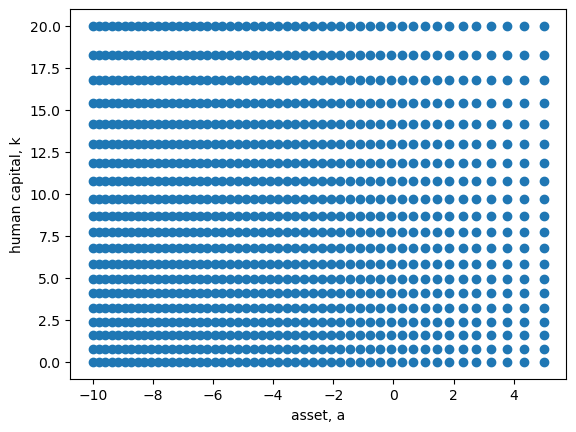

In [4]:
fig, ax = plt.subplots()
a_mesh,k_mesh = np.meshgrid(par.a_grid,par.k_grid,indexing='ij')
ax.scatter(a_mesh,k_mesh)
ax.set(xlabel='asset, a',ylabel='human capital, k');

## Solve the model

In [5]:
%time model.solve()

CPU times: user 17.2 s, sys: 69.6 ms, total: 17.2 s
Wall time: 17.4 s


<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/var/folders/zt/5m4wvxh535lc12y4ttsgzt2m0000gn/T/ipykernel_20384/1997275382.py:7: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Consumption, $c_{T}^{\star}$');
/var/folders/zt/5m4wvxh535lc12y4ttsgzt2m0000gn/T/ipykernel_20384/1997275382.py:13: SyntaxWarning: invalid escape sequence '\s'
  ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Hours, $h_{T}^{\star}$');


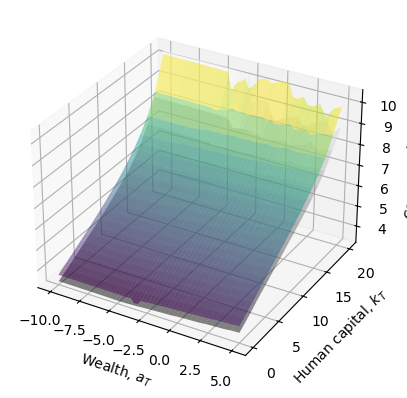

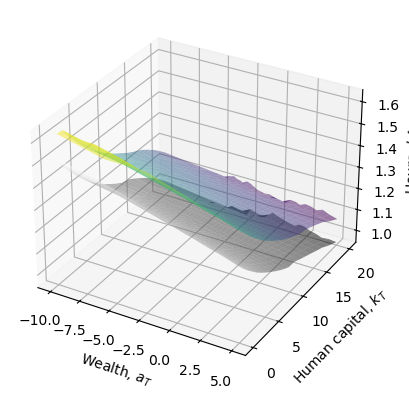

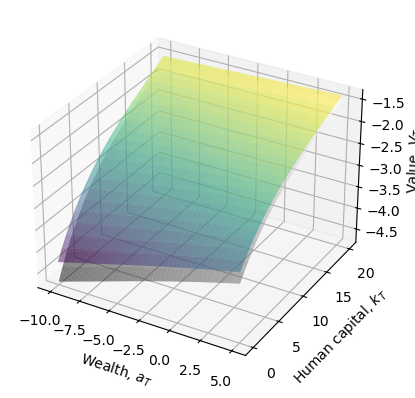

In [6]:
# first period
t = 0
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.c[t,0],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.5);
ax.plot_surface(a_mesh, k_mesh, sol.c[t,1],rstride=1,cstride=1,cmap='gray', edgecolor='none',alpha=0.5);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Consumption, $c_{T}^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.h[t,0],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.5);
ax.plot_surface(a_mesh, k_mesh, sol.h[t,1],rstride=1,cstride=1,cmap='gray', edgecolor='none',alpha=0.5);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Hours, $h_{T}^{\star}$');

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, k_mesh, sol.V[t,0],rstride=1,cstride=1,cmap='viridis', edgecolor='none',alpha=0.5);
ax.plot_surface(a_mesh, k_mesh, sol.V[t,1],rstride=1,cstride=1,cmap='gray', edgecolor='none',alpha=0.5);
ax.set(xlabel='Wealth, $a_{T}$',ylabel='Human capital, $k_T$',zlabel='Value, $V_{T}$');

## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question

# Simulation

With the solution at hand we can now simulate `simN` synthetic individuals for `simT` periods. We do so by initializing all state-variables in the first period and simulate forwards. 

Initial number of children, wealth and human capital are the state variables in our model, and we start by initilizing all individuals with no children `sim.n_init=np.zeros(par.simN,dtype=np.int_)`, no wealth, `sim.a_init=np.zeros(par.simN)` and no human capital `sim.k_init=np.zeros(par.simN)`. <br>
We also need to draw from a random uniform distribution todetermine whether a child arrives in each period. We call these `sim.draws_uniform`

We then loop forward using the solution:
$$
\begin{align}
c_{i,t} &= c_t^{\star}(n_{i,t},a_{i,t},k_{i,t}) \\
h_{i,t} &= h_t^{\star}(n_{i,t},a_{i,t},k_{i,t}) \\
y_{i,t} &= (1-\tau) \cdot  w\cdot(1+\alpha k_{i,t}) \cdot h_{i,t}\\
a_{i,t+1} &= (1+r)(a_{i,t} + y_{i,t} - c_{i,t})\\
k_{i,t+1} &= k_{i,t} + h_{i,t}\\
n_{i,t+1} &= n_{i,t} + b_{i,t}\\
\end{align}
$$
where $b_{i,t}\in\{0,1\}$ denotes a birth. See formulation in the top and the code for the construction.

In [7]:
model.simulate()

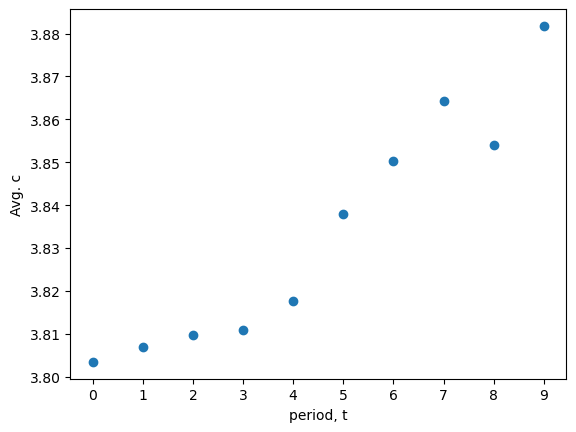

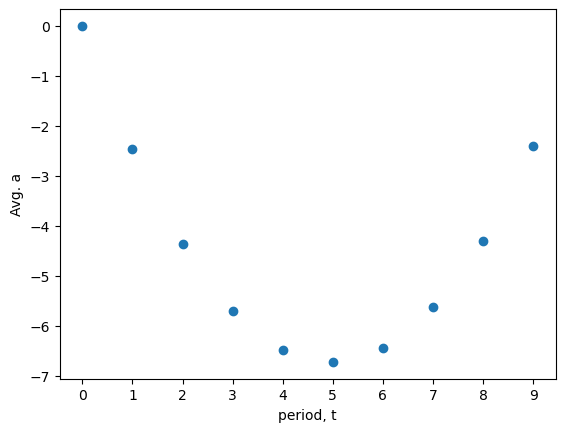

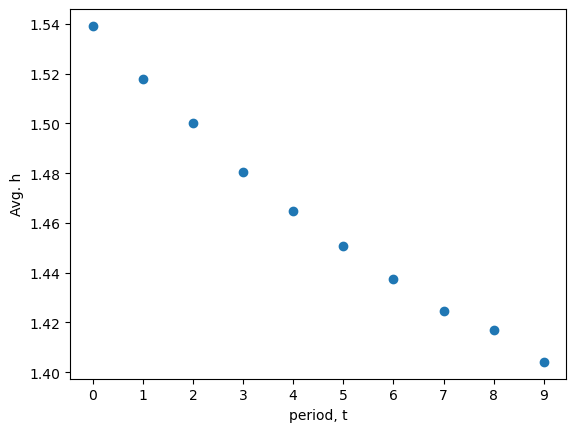

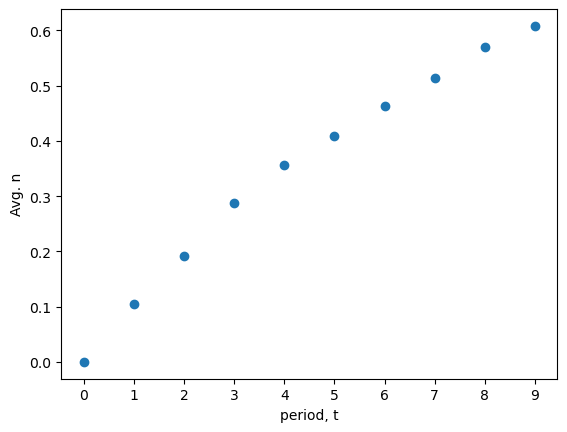

In [8]:
# plot behavior
for var in ('c','a','h','n'):
    fig, ax = plt.subplots()
    ax.scatter(range(par.simT),np.mean(getattr(sim,var),axis=0),label='Simulated')
    ax.set(xlabel='period, t',ylabel=f'Avg. {var}',xticks=range(par.simT));

## In-class exercise

1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question

# Event-study graphs around childbirth

**construct relative time variable**

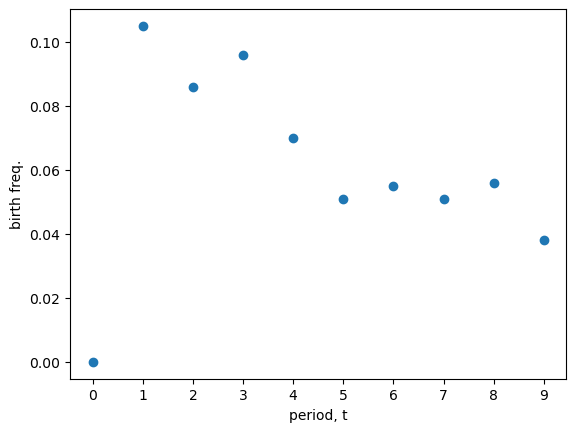

In [9]:
# birth
birth = np.zeros(sim.n.shape,dtype=np.int_)
birth[:,1:] = (sim.n[:,1:] - sim.n[:,:-1]) > 0
fig, ax = plt.subplots()
ax.scatter(range(par.simT),np.mean(birth,axis=0))
ax.set(xlabel='period, t',ylabel=f'birth freq.',xticks=range(par.simT));

In [10]:
# time since birth
periods = np.tile([t for t in range(par.simT)],(par.simN,1))
time_of_birth = np.max(periods * birth, axis=1)

I = time_of_birth>0
time_of_birth[~I] = -1000 # never as a child
time_of_birth = np.transpose(np.tile(time_of_birth , (par.simT,1)))

time_since_birth = periods - time_of_birth

In [11]:
# calculate average outcome across time since birth
min_time = -8
max_time = 8
event_grid = np.arange(min_time,max_time+1)

event_hours = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours[t] = np.mean(sim.h[time_since_birth==time])

# relative to period before birth
event_hours_rel = event_hours - event_hours[event_grid==-1]


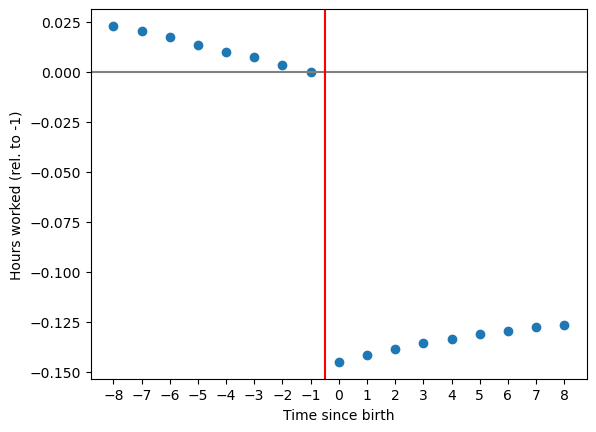

In [12]:
fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel)
ax.axhline(y=0,color='gray')
ax.axvline(x=-0.5,color='red')
ax.set(xlabel='Time since birth',ylabel=f'Hours worked (rel. to -1)',xticks=event_grid);

**Question 1:** Plot the event-study graph for people who had a birth in period $t=2$ and those who had one in period $t=4$. <br>
**Question 2:** Why is the event-study graph downwards sloping before childbirth? <br>
**Question 3:** Why is the event-study graph upwards sloping after childbirth in the combined figure above? <br>

In [13]:
# YOUR CODE HERE

In [ ]:
# Solution
event_hours_cond = {}
for period in range(1,9):
    event_hours_cond[period] = np.nan + np.zeros(event_grid.size)

    for t,time in enumerate(event_grid):
        I = (time_since_birth==time) & (time_of_birth==period)
        event_hours_cond[period][t] = np.mean(sim.h[I])

    # relative
    event_hours_cond[(period,'rel')] = event_hours_cond[period] - event_hours_cond[period][event_grid==-1]
    

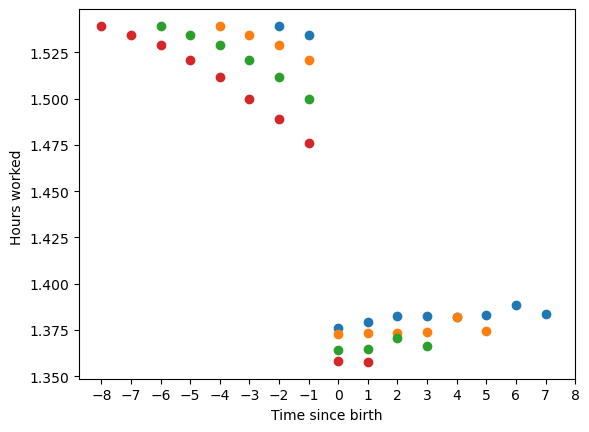

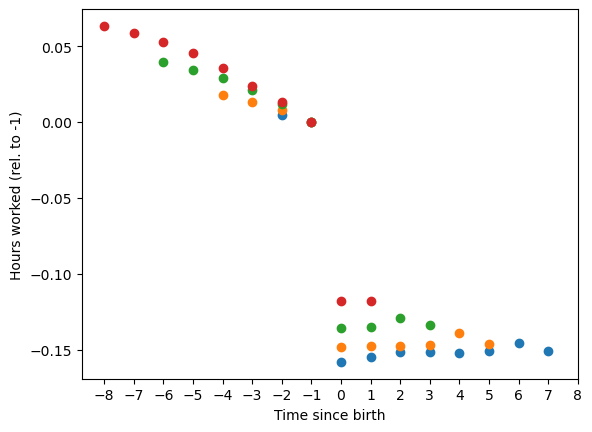

In [15]:
fig, ax = plt.subplots()
for period in (2,4,6,8):
    ax.scatter(event_grid,event_hours_cond[(period)])
ax.set(xlabel='Time since birth',ylabel=f'Hours worked ',xticks=event_grid);

fig, ax = plt.subplots()
for period in (2,4,6,8):
    ax.scatter(event_grid,event_hours_cond[(period,'rel')])
ax.set(xlabel='Time since birth',ylabel=f'Hours worked (rel. to -1)',xticks=event_grid);